In [135]:
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)
import Dataloader as _D
reload(_D)

<module 'Dataloader' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\Dataloader.py'>

In [142]:
PORTFOLIO_v0 = list(_C.commodities.keys())
PORTFOLIO_v1 = ['rb', 'hc', 'i', 'm', 'bu', 'SA']
PORTFOLIO_v2 = ['rb', 'hc', 'MA', 'l', 'p', 'v', 'CF']
PORTFOLIO_v3 = ['p']

In [140]:
PORTFOLIO = PORTFOLIO_v3

### Pnl

In [141]:
Pnl = {}
total_d_gain = pd.Series([])
total_d_gain = total_d_gain.reindex(_C.BACKTEST_VTD).fillna(0)

# for com in _D.commodities.keys():
for com in _D.commodities.keys():
    com_balance= pd.read_csv(f'output/balance_sheet/{_C.VERSION}/{com}_balance.csv')
    com_balance = com_balance.set_index(com_balance.columns[0])
    Pnl[com] = com_balance['Pnl']
    if com in PORTFOLIO:
        total_d_gain += com_balance['d_gain']

Pnl['portfolio'] = 1 + total_d_gain.cumsum()/(len(PORTFOLIO) * _C.INIT_CAP)

FileNotFoundError: [Errno 2] No such file or directory: 'output/balance_sheet/v3/MA_balance.csv'

In [103]:
def draw_pnl(scom):
    fig, axes = plt.subplots(figsize=(10, 5), dpi=80)
    plt.title(f'{scom} Pnl')
    Pnl[scom].plot()

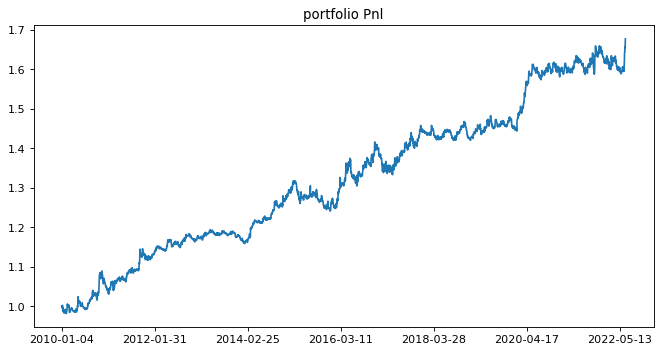

In [104]:
draw_pnl('portfolio')

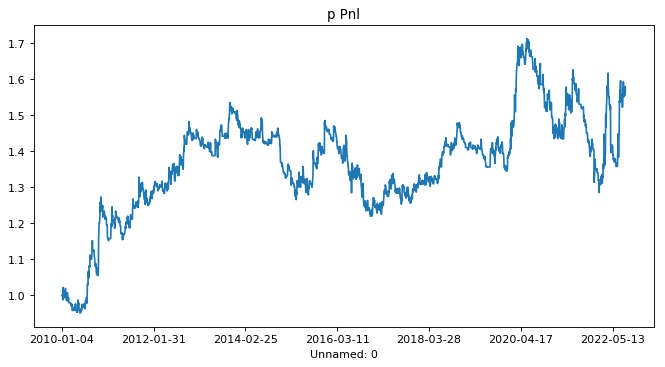

In [105]:
draw_pnl('p')

In [106]:
with open(f'./output/v_analysis/{_C.VERSION}/Pnl.pkl', 'wb') as f:
    pickle.dump(Pnl, f)

In [107]:
def profitable_analysis(_pnl):
    report = pd.DataFrame(columns=['Annual Return', 'Std', 'Sharpe', 'MaxDrawdown', 'Calmar'])
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - list(_pnl)/pd.Series(list(_pnl.rolling(len(_pnl)))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    report.loc[report.shape[0]] = [Annual_r, Std, Sharpe, MaxDrawdown, Calmar]
    return report

In [108]:
profitable_analysis(Pnl['portfolio'])

,Annual Return,Std,Sharpe,MaxDrawdown,Calmar
0,0.044397,0.052304,0.84882,0.058336,0.761059


### Win-Loss

In [109]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

for com in _C.commodities.keys():
    com_log = np.load(f'output/trading_logs/{_C.VERSION}/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

    if com in PORTFOLIO:
        all_buy = all_buy.append(com_log[0])
        all_sell = all_sell.append(com_log[1])
        all_total = all_total.append(com_log[2])

trading_logs['portfolio'] = [all_buy, all_sell, all_total]

In [110]:
def cal_win_rate(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].shape[0] / _df_['gain'].shape[0], 4)

def cal_win_loss_ratio(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].sum() / _df_['gain'].loc[_df_['gain']<0].sum() * -1, 4)

In [111]:
cols = ['BUY_wr', 'SELL_wr', 'TOTAL_wr', 'BUY_wlr', 'SELL_wlr', 'TOTAL_wlr']
symbols = list(_D.commodities.keys())+['portfolio']

In [112]:
Win_Loss_Analysis = pd.DataFrame(columns=symbols)
WLA = Win_Loss_Analysis.reindex(cols).transpose()

In [113]:
for com in symbols:
    buy_log = trading_logs[com][0]
    sell_log= trading_logs[com][1]
    total_log = trading_logs[com][2]

    WLA['BUY_wr'][com] = cal_win_rate(buy_log)
    WLA['SELL_wr'][com] = cal_win_rate(sell_log)
    WLA['TOTAL_wr'][com] = cal_win_rate(total_log)

    WLA['BUY_wlr'][com] = cal_win_loss_ratio(buy_log)
    WLA['SELL_wlr'][com] = cal_win_loss_ratio(sell_log)
    WLA['TOTAL_wlr'][com] = cal_win_loss_ratio(total_log)

In [114]:
WLA

,BUY_wr,SELL_wr,TOTAL_wr,BUY_wlr,SELL_wlr,TOTAL_wlr
rb,0.3384,0.3248,0.3291,1.3729,1.2174,1.2576
hc,0.3477,0.2953,0.3333,1.5112,0.8504,1.2573
i,0.278,0.3006,0.2885,1.1101,1.2753,1.1967
m,0.3516,0.291,0.3208,1.0446,0.8528,0.92
pp,0.2812,0.3333,0.3081,0.8495,1.0997,0.991
MA,0.3283,0.3598,0.3534,1.0027,1.2597,1.1973
bu,0.2626,0.2892,0.276,1.0574,1.1479,1.1306
l,0.2943,0.3005,0.3002,0.8852,1.1249,1.0106
p,0.3032,0.3199,0.3126,0.8999,1.3108,1.1238
v,0.2798,0.3113,0.3117,0.9376,1.0351,1.1355


In [115]:
WLA.to_csv(f'./output/v_analysis/{_C.VERSION}/Win-Loss.csv')

In [118]:
cc = pd.read_csv('./output/v_analysis/v2/Win-Loss.csv', index_col=0)

### Positions

#### Positions Holding Time

In [120]:
hold_t = {}
all_hold_t = []
all_hold_t = pd.Series(all_hold_t)

for com in _C.commodities.keys():
    _df = trading_logs[com][2].copy(deep=True)

    delta_t = pd.to_datetime(_df['close_date']) - pd.to_datetime(_df['open_date'])
    _df['hold_t'] = (delta_t).apply(lambda x: x.total_seconds()/60)

    hold_t[com] = _df['hold_t']
    if com in PORTFOLIO:
        all_hold_t = all_hold_t.append(_df['hold_t'])

hold_t['portfolio'] = all_hold_t

In [121]:
def hold_t_analysis(scom):
    ht = hold_t[scom]
    print(ht.describe())
    ht.hist(bins=20)

In [122]:
cols_2 = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
HTA = pd.DataFrame(columns=symbols)
HTA = HTA.reindex(cols_2).transpose()

In [123]:
for com in symbols:
    ht = hold_t[com]
    des = list(ht.describe())
    for i in cols_2:
        HTA[i][com] = round(int(des[cols_2.index(i)])/60, 1) if cols_2.index(i)>0 else des[cols_2.index(i)]

In [124]:
HTA # Holding Period Time

,count,mean,std,min,25%,50%,75%,max
rb,793,70.6,108.8,0,0,24,96,840
hc,558,67.6,128.1,0,0,24,72,1320
i,558,62.9,94.5,0,0,24,72,888
m,904,67,103.8,0,0,24,72,888
pp,516,68.2,98.6,0,0,24,96,768
MA,566,59.5,83.9,0,0,24,72,672
bu,645,59.1,93.1,0,0,24,72,888
l,643,86.1,131.7,0,0,24,120,1032
p,899,62.9,92.8,0,0,24,72,696
v,677,90,139.3,0,24,48,96,1128


In [134]:
HTA.to_csv(f'./output/v_analysis/{_C.VERSION}/HTA.csv')

#### Daily Trade Num

In [128]:
trade_num = {}
F_data = pd.read_pickle(f'dataset/F_data_{_C.TIME_FRAME}.pkl')
VTD = F_data['VTD']
all_trade_num = pd.Series([0 for i in range(len(VTD))])

for com in _D.commodities.keys():
    tn = [0 for i in range(len(VTD))]
    com_log = trading_logs[com]
    _df = com_log[2].copy(deep=True)

    for i in range(_df.shape[0]):
        entry = _df.iloc[i]
        tn[VTD.index(entry['open_date'])] += 1
        tn[VTD.index(entry['close_date'])] += 1
    
    trade_num[com] = tn
    if com in PORTFOLIO:
        all_trade_num += pd.Series(tn)

trade_num['portfolio'] = all_trade_num.to_list()

In [130]:
DTN = pd.DataFrame()
DTN = DTN.reindex(VTD)

for com in symbols:
    DTN[com] = trade_num[com]

In [131]:
DTN # Daily Trade Num

,rb,hc,i,m,pp,MA,bu,l,p,v,CF,OI,SR,TA,SA,portfolio
2010-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2
2010-01-06,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,1
2010-01-07,1,0,0,1,0,0,0,3,0,1,1,0,2,3,0,6
2010-01-08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,1,2,1,3,1,0,0,1,4,2,0,2,1,0,0,10
2022-08-16,0,0,1,0,1,0,0,2,0,2,0,1,1,2,1,4
2022-08-17,0,0,1,0,0,0,0,1,1,0,0,0,3,0,0,2
2022-08-18,1,1,1,0,1,1,2,1,1,0,1,0,0,2,1,6


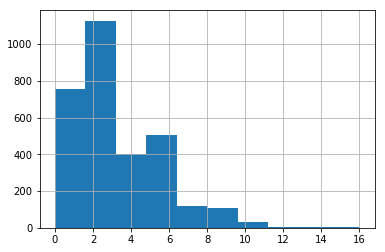

In [132]:
DTN['portfolio'].hist()

In [133]:
DTN.to_csv(f'./output/v_analysis/{_C.VERSION}/DTN.csv')

### Version Comparation

In [35]:
Pnl.keys()

dict_keys(['rb', 'hc', 'i', 'm', 'pp', 'MA', 'bu', 'l', 'p', 'v', 'CF', 'OI', 'SR', 'TA', 'SA', 'total'])

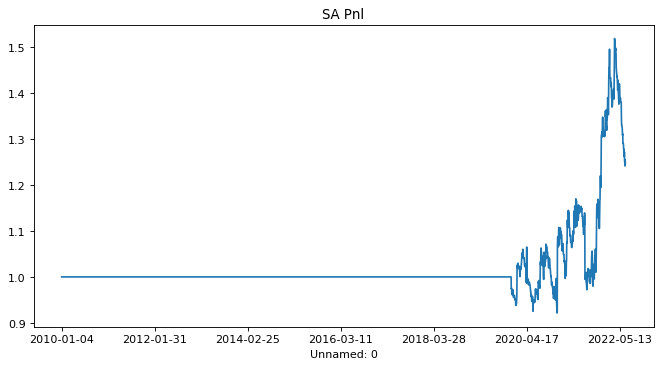

In [50]:
draw_pnl('SA')